# Chest X-rays 

Dataset from: https://stanfordmlgroup.github.io/competitions/chexpert/ 

What is CheXpert?
CheXpert is a large dataset of chest X-rays and competition for automated chest x-ray interpretation, which features uncertainty labels and radiologist-labeled reference standard evaluation sets.

The goal:
* Create a deep learning system able to detect one or more of 14 conditions directly from one or more 
  chest X-rays.

## Setup

In [1]:
%matplotlib inline
from fastai.vision.all import *
from pathlib import Path

In [2]:
!pip install graphviz

In [3]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
!pip install kaggle

## Get the Data

In [4]:
DATA = Path("../DAT255 - 2022")

In [5]:
import shutil
if not os.path.exists(DATA/'CheXpert-v1.0-small'):
    shutil.unpack_archive(DATA/'CheXpert-v1.0-small.zip', extract_dir=DATA)

In [6]:
trainData = pd.read_csv('CheXpert-v1.0-small/train.csv')
validData = pd.read_csv('CheXpert-v1.0-small/valid.csv')

## Data Cleaning

All the NaN values get the value 0.  

In [7]:
#The target columns
chexpert_targets=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 
                  'Consolidation','Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
                  'Fracture', 'Support Devices']

In [8]:
trainData = trainData.fillna(0)
validData = validData.fillna(0)

Dropping the -1 values, replacing them with 0

In [9]:
trainData = trainData.replace(-1,0)
validData = validData.replace(-1,0)

In [10]:
trainData.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/view1_frontal.jpg,Female,87,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,CheXpert-v1.0-small/train/patient00002/study1/view1_frontal.jpg,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CheXpert-v1.0-small/train/patient00002/study1/view2_lateral.jpg,Female,83,Lateral,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,CheXpert-v1.0-small/train/patient00003/study1/view1_frontal.jpg,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
trainData['train_valid'] = False
validData['train_valid'] = True

Making columns for 'study' and 'patient':

In [12]:
trainData['patient'] = trainData.Path.str.split('/',3,True)[2]
trainData  ['study'] = trainData.Path.str.split('/',4,True)[3]

validData['patient'] = trainData.Path.str.split('/',3,True)[2]
validData  ['study'] = trainData.Path.str.split('/',4,True)[3]

In [13]:
#Making a new dataframe with both the training and validation data
full_df = pd.concat([trainData, validData])

Making a column for feature string:

In [14]:
def feature_string(row):
    feature_list = []
    for feature in chexpert_targets:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

In [15]:
full_df['feature_string'] = full_df.apply(feature_string,axis = 1).fillna('')

In [16]:
full_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study,feature_string
0,CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,patient00001,study1,No Finding;Support Devices
1,CheXpert-v1.0-small/train/patient00002/study2/view1_frontal.jpg,Female,87,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,patient00002,study2,Lung Opacity;Fracture
2,CheXpert-v1.0-small/train/patient00002/study1/view1_frontal.jpg,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,patient00002,study1,Lung Opacity;Fracture
3,CheXpert-v1.0-small/train/patient00002/study1/view2_lateral.jpg,Female,83,Lateral,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,patient00002,study1,Lung Opacity;Fracture
4,CheXpert-v1.0-small/train/patient00003/study1/view1_frontal.jpg,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,patient00003,study1,Edema


In [17]:
print(len(full_df))

223648


Removing a large portion of the data because of training time. 

In [18]:
full_df = full_df.drop(full_df.index[100000:220000])

In [19]:
print(len(full_df))

103648


## Constructing a DataBlock

In [20]:
img_path=DATA/'CheXpert-v1.0-small/train.csv'

In [21]:
dblock=DataBlock()

In [22]:
dsets=dblock.datasets(full_df)

In [23]:
len(dsets.train), len(dsets.valid)

(82919, 20729)

In [24]:
x,y = dsets.train[0]
x,y

(Path                          CheXpert-v1.0-small/train/patient00361/study1/view1_frontal.jpg
 Sex                                                                                      Male
 Age                                                                                        73
 Frontal/Lateral                                                                       Frontal
 AP/PA                                                                                      AP
 No Finding                                                                                0.0
 Enlarged Cardiomediastinum                                                                0.0
 Cardiomegaly                                                                              0.0
 Lung Opacity                                                                              0.0
 Lung Lesion                                                                               0.0
 Edema                                            

In [25]:
x['Path']

'CheXpert-v1.0-small/train/patient00361/study1/view1_frontal.jpg'

In [26]:
dblock = DataBlock(get_x = lambda r: r['Path'], get_y = lambda r: r['feature_string'])
dsets = dblock.datasets(full_df)
dsets.train[7]

('CheXpert-v1.0-small/train/patient15462/study3/view1_frontal.jpg',
 'Lung Opacity;Pleural Effusion')

In [27]:
def get_x(r): return DATA/r['Path']
#splitting the 'feature_string' where there is a ;
def get_y(r): return r['feature_string'].split(';') 
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(full_df)
dsets.train[0]

(Path('../DAT255 - 2022/CheXpert-v1.0-small/train/patient15558/study32/view1_frontal.jpg'),
 ['Lung Opacity',
  'Edema',
  'Consolidation',
  'Pleural Effusion',
  'Support Devices'])

In [28]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(full_df)
dsets.train[0]

(PILImage mode=RGB size=320x351,
 TensorMultiCategory([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]))

In [29]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#3) ['Consolidation','Lung Opacity','Pneumonia']

In [30]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.4))
dls = dblock.dataloaders(full_df)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


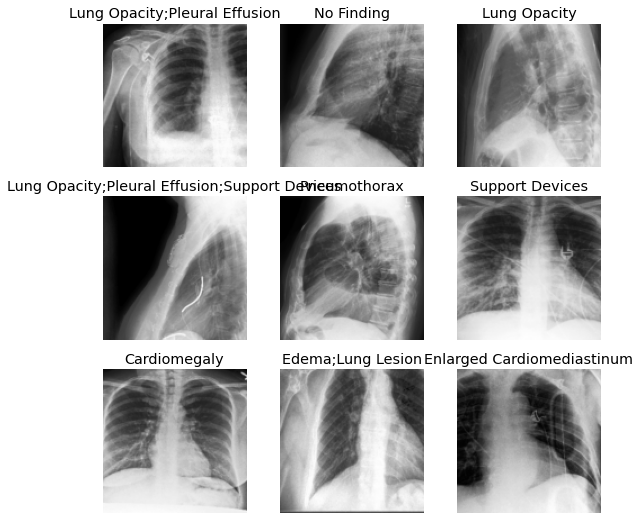

In [31]:
dls.show_batch()

## Binary Cross-Entropy

In [32]:
learn=cnn_learner(dls, resnet18)

In [33]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 15])

In [34]:
activs[0]

TensorBase([-1.2696e+00,  3.6787e+00,  3.3888e-03, -1.3744e+00, -5.7248e-01,  1.3235e+00,  2.5224e+00,  2.1858e+00,  1.1397e+00, -1.9025e+00,  1.8981e+00, -5.5784e-01,  3.3867e+00, -2.8393e+00,
         4.2594e+00], grad_fn=<AliasBackward0>)

In [35]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs).log().mean()

In [36]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0104, grad_fn=<AliasBackward0>)

## Train the Model

In [37]:
if not os.path.exists(DATA/'export.pkl'):
    learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.2))
    #learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)
    learn.fit_one_cycle(4, 5e-3, wd=0.1)

In [38]:
if not os.path.exists(DATA/'export.pkl'):
    learn.export()

In [39]:
if not os.path.exists(DATA/'export.pkl'):
    learn.save('chexpert_model')

In [40]:
DATA.ls(file_exts='.pkl')

(#1) [Path('../DAT255 - 2022/export.pkl')]

In [41]:
learn_inf = load_learner(DATA/'export.pkl')

## Making a Notebook App

In [42]:
learn_inf = load_learner(DATA/'export.pkl')

In [43]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

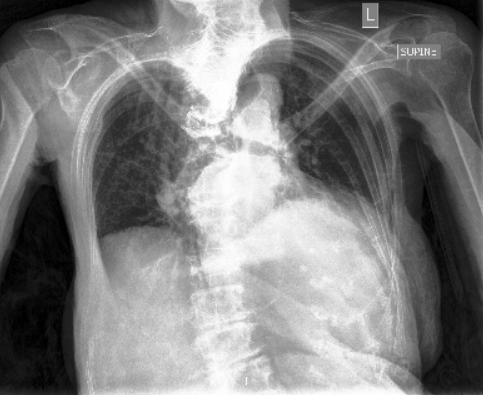

In [45]:
img = PILImage.create(btn_upload.data[-1])
img

In [46]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [47]:
pred,pred_idx,probs = learn_inf.predict(img)

In [48]:
lbl_pred = widgets.Label()
probability = {probs[pred_idx]}
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]}'
#lbl_pred.value="$2.3f"%probs[pred_idx]
lbl_pred

Label(value="Prediction: ['Lung Opacity']; Probability: TensorBase([0.5017])")

In [49]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [50]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]}'

btn_run.on_click(on_click_classify)

In [51]:
btn_upload = widgets.FileUpload()

In [52]:
from ipywidgets import *
VBox([widgets.Label('Select your x-ray!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

## Turning the Notebook into a real App

In [54]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 6.4.2
    Uninstalling nbconvert-6.4.2:
      Successfully uninstalled nbconvert-6.4.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 4.2.5 requires pyqt5<5.13, which is not installed.
spyder 4.2.5 requires pyqtwebengine<5.13, which is not installed.
Enabling: voila
- Writing config: C:\Users\malin\anaconda3\etc\jupyter
    - Validating...
      voila 0.3.5 ok
